In [1]:
''' IMPORTS, RELOAD THIS BLOCK WHEN NEEDED '''

from IPython.display import display
from GoogleImageSpider import *
from ImageNormalizer import *
from ImageClassifier import *
import certifi, urllib3
import time
import json
import os

path = "pokemon_images"
images_per_pokemon = 100
start_time = time.time()

def print_time():
    # TIMING CONTROL
    elapsed_time = time.time() - start_time
    mins = int(elapsed_time / 60)
    secs = elapsed_time - (mins * 60)
    print("Accumulative time: %02d:%02d" % (mins, int(secs % 60)))

In [2]:
''' FIRST STEP GET A "SMALL" SAMPLE OF POKEMON IMAGES (LET ONLY DO 3 OR 4 POKEMONS AND STOP IT) 
    THAT WILL MEAN 300 or 400 POKEMON IMAGES '''

if not os.path.exists(path):
    os.makedirs(path)
    
start_time = time.time()

# FIRST USE A POKEMON API TO GET EACH POKEMON NAME:
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
json_string = http.request('GET', 'https://pokeapi.co/api/v2/pokemon/?limit=1000')
json_string = json_string.data.decode('utf-8')
pokemons = json.loads(json_string)
print("Pokemons in API: ", len(pokemons['results']))
print_time()

# SECOND STEP DOWNLOAD IMAGES FROM EACH POKEMON NAME:
gis = GoogleImageSpider()
i = 0
for poketemp in pokemons['results']:
    # SKIP SOME OF THEM BETWEEN DOWNLOADS TO NOT DOWNLOAD SIMILAR IMAGES FROM EVOLUTIONS
    i += 1
    if i % 200 != 0:
        continue
        
    gis.get_images("pokemon " + poketemp['name'] + " image", images_per_pokemon)
    gis.save_images(poketemp['name'], path)
    gis.clear()
    print ("Pokemon number", i, ", ", poketemp['name'], ", downloaded")
    print_time()

print ("All pokemon images downloaded")
print_time()

Pokemons in API:  949
Accumulative time: 00:08
Looking for:  pokemon+misdreavus+image
100 images saved to:  pokemon_images
misdreavus downloaded
Accumulative time: 00:43
Looking for:  pokemon+bibarel+image
100 images saved to:  pokemon_images
bibarel downloaded
Accumulative time: 01:25
Looking for:  pokemon+klang+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  pokemon_images
klang downloaded
Accumulative time: 02:36
Looking for:  pokemon+necrozma+image
100 images saved to:  pokemon_images
necrozma downloaded
Accumulative time: 03:21
All pokemon images downloaded
Accumulative time: 03:21


Normalizing..
Something goes wrong trying to process image  necrozma73.jpg : <class 'OSError'>
Something goes wrong trying to process image  klang83.png : <class 'OSError'>
Something goes wrong trying to process image  klang43.jpg : <class 'OSError'>
Something goes wrong trying to process image  klang71.jpg : <class 'OSError'>


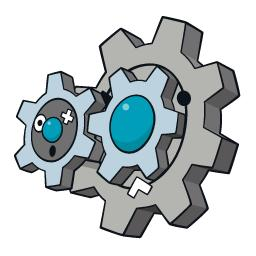

Accumulative time: 00:25
Done!


In [3]:
''' SECOND STEP: NORMALIZE THAT POKEMONS IN ORDER TO USE OUR CLAFSSIFICATION NETWORK '''

start_time = time.time()

im = ImageNormalizer(path)
im.normalize((256, 256), "pkm_destin_images")

filename, file_extension = os.path.splitext(os.listdir(path)[0])
display(Image.open("pkm_destin_images"+"/"+ filename + ".jpg"))
print_time()
print ("Done!")

In [ ]:
''' THIRD STEP: NOW WE SHOULD MANUALLY CREATE A SAMPLE FOR OUR NEURAL NETWORK 
    DISCRIMINATING GOOD AND BAD IMAGES INTO A SEPARATED FOLDERS ("GOOD" AND "BAD").
    YES IT IS MANUAL WORK HERE, BUT IF YOU THINK ABOUT IT, IT IS COOL ENOUGH..
    IF YOU DO ONLY 300 IMAGES AND THE NEURAL NETWORK CREATES 50.000 
    
    IN MY CASE (POKEMONS) I TRIED TO REMOVE CONSECUTIVE NUMBERS TO AVOID EVOLUTIONS 
    AND SIMILAR POKEMONS IN FIRST STEP (THAT'S WHY THE if i % 200 != 0: continue ).
    AND I WILL TRY TO DISCRIMINATE ALL NON SINGLE-WHITE BACKGROUND POKEMONS'''

In [1]:
''' FOURTH STEP: IS TO TRAIN A NETWORK WITH THIS IMAGES (I MADE ONE SIMPLE 
    CONVOLUTIONAL CLASSIFIER, FEEL FREE TO UPDATE IT AND SEND A PUSH IT TO THE REPO)'''

from ImageClassifier import *
good_images_folder = "pkm_classifier/good"
bad_images_folder = "pkm_classifier/bad"
start_time = time.time()

ic = ImageClassifier(good_images_folder, bad_images_folder, 256, batch_size=50, training_epochs=1000, \
                    test_batch_percentage = 0) # Once proved that works, we need to use all possible inputs
#ic.test()
ic.train()

Epoch:  0
Accuracy for batch: 0.39999998 / Accuracy for validation: nan
Accumulative time: 00:11
----------------------
Epoch:  100
Accuracy for batch: 0.82 / Accuracy for validation: nan
Accumulative time: 00:55
----------------------
Epoch:  200
Accuracy for batch: 0.87999994 / Accuracy for validation: nan
Accumulative time: 01:39
----------------------
Epoch:  300
Accuracy for batch: 0.98 / Accuracy for validation: nan
Accumulative time: 02:23
----------------------
Epoch:  400
Accuracy for batch: 1.0 / Accuracy for validation: nan
Accumulative time: 03:08
----------------------
Epoch:  500
Accuracy for batch: 0.98 / Accuracy for validation: nan
Accumulative time: 03:52
----------------------
Epoch:  600
Accuracy for batch: 1.0 / Accuracy for validation: nan
Accumulative time: 04:37
----------------------
Epoch:  700
Accuracy for batch: 1.0 / Accuracy for validation: nan
Accumulative time: 05:22
----------------------
Epoch:  800
Accuracy for batch: 1.0 / Accuracy for validation: na

In [ ]:
''' LAST STEP: FINALLY WE MIX ALL THAT TOGETHER, DOWNLOAD ALL THE DATASET, NORMALIZE,
    AND LET OUR NEURAL NETWORK DISCRIMINATE THEM TO GET ONLY THE GOOD ONES.
    
    THIS IS PRETTY MUCH COPY OF THE FIRST STEP CODE IMPROVED.
    
    WE ARRIVE HERE IN LIKE 15 MINUTES, BUT NOW 100 IMAGES PER 949 POKEMONS WILL TAKE A WHILE.. 
    TAKE A COFEE AND COME BACK IN A FEW  HOURS ;) 
    GOOD NEWS IS THAT IS COMPLETELY FREE OF HUMAN INTERACTION '''

originals_temp_path = "pkm_original_images"
source_path = "pkm_destin_images"
good_images_folder = source_path+"/good"
bad_images_folder = source_path+"/bad"
images_per_pokemon = 100
start_time = time.time()
    
if not os.path.exists(originals_temp_path):
    os.makedirs(originals_temp_path)

print ("Loading CNN..")
ic = ImageClassifier(None, None, 256)
ic.load()

print ("Loading Normalizer..")
im = ImageNormalizer(originals_temp_path)

print ("Accessing Pokemons..")
# FIRST USE A POKEMON API TO GET EACH POKEMON NAME:
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
json_string = http.request('GET', 'https://pokeapi.co/api/v2/pokemon/?limit=1000')
json_string = json_string.data.decode('utf-8')
pokemons = json.loads(json_string)
print("Pokemons in API: ", len(pokemons['results']))
print_time()

# SECOND STEP DOWNLOAD IMAGES FROM EACH POKEMON NAME:
i = 0
gis = GoogleImageSpider()
for poketemp in pokemons['results']:
    i += 1
    gis.get_images("pokemon " + poketemp['name'] + " image", images_per_pokemon)
    gis.save_images(poketemp['name'], originals_temp_path)
    im.normalize((256, 256), source_path, delete_originals=True)
    ic.run(source_path, good_images_folder, bad_images_folder, good_percent_treshold=85, delete_images=True)
    gis.clear()
    print ("Pokemon number", i, ", ", poketemp['name'], ", processed")
    print_time()
    sys.stdout.flush() # For python command line

print ("Dataset finally done!")
print_time()


Loading CNN..
INFO:tensorflow:Restoring parameters from CNN/saved_cnn.ckpt
Loading Normalizer..
Accessing Pokemons..
Pokemons in API:  949
Accumulative time: 00:06
Looking for:  pokemon+bulbasaur+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
bulbasaur processed
Accumulative time: 01:07
Looking for:  pokemon+ivysaur+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
ivysaur processed
Accumulative time: 02:06
Looking for:  pokemon+venusaur+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
Something g

100 images saved to:  original_images
Normalizing..
ninetales processed
Accumulative time: 60:39
Looking for:  pokemon+jigglypuff+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
jigglypuff processed
Accumulative time: 62:47
Looking for:  pokemon+wigglytuff+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
wigglytuff processed
Accumulative time: 64:47
Looking for:  pokemon+zubat+image
100 images saved to:  original_images
Normalizing..
zubat processed
Accumulative time: 67:00
Looking for:  pokemon+golbat+image
100 images saved to:  original_images
Normalizing..
golbat processed
Accumulative time: 68:36
Looking for:  pokemon+oddish+image
100 images saved to:  original_images
Normalizing..
oddish processed
Accumula

100 images saved to:  original_images
Normalizing..
graveler processed
Accumulative time: 143:48
Looking for:  pokemon+golem+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
golem processed
Accumulative time: 145:47
Looking for:  pokemon+ponyta+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
ponyta processed
Accumulative time: 148:08
Looking for:  pokemon+rapidash+image
100 images saved to:  original_images
Normalizing..
rapidash processed
Accumulative time: 151:07
Looking for:  pokemon+slowpoke+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
slowpoke processed
Accumulative time: 153:17
Looking for:  pokemon+slowbro

100 images saved to:  original_images
Normalizing..
seaking processed
Accumulative time: 245:39
Looking for:  pokemon+staryu+image
100 images saved to:  original_images
Normalizing..
staryu processed
Accumulative time: 248:01
Looking for:  pokemon+starmie+image
100 images saved to:  original_images
Normalizing..
starmie processed
Accumulative time: 250:15
Looking for:  pokemon+mr-mime+image
100 images saved to:  original_images
Normalizing..
mr-mime processed
Accumulative time: 252:30
Looking for:  pokemon+scyther+image
Something goes wrong trying to save image:  <class 'urllib3.exceptions.MaxRetryError'>
100 images saved to:  original_images
Normalizing..
scyther processed
Accumulative time: 254:48
Looking for:  pokemon+jynx+image
100 images saved to:  original_images
Normalizing..
jynx processed
Accumulative time: 257:05
Looking for:  pokemon+electabuzz+image
100 images saved to:  original_images
Normalizing..
electabuzz processed
Accumulative time: 259:20
Looking for:  pokemon+magma

In [ ]:
''' HINT1: EXECUTE THIS LAST STEP IN A STANDALONE PYTHON EXECUTABLE CAUSE MY JUPYTER NOTEBOOK
    FREEZES AT 5 HOURS (AT LEAST MINE) AND THIS IS A 18H PROCESS MORE OR LESS (THIS IS WHAT I 
    GET NEXT DAY, AND A MESSAGE TELLING ME MY KERNEL IS STOPPED)

    HINT2: ONCE YOU HAVE A MORE LENGTH ON YOUR ALREADY CREATED DATASET YOU CAN REPEAT THE 
    PROCESS HELPING MANUALLY THE NETWORK TO GET BETTER AND THAT WAY FINALLY CREATE A HUGE 
    AND ALMOST PERFECT DATASET (IT IS ABOUT STATISTICS NOT PERFECTION, DO NOT OBSESS)'''

![FINAL DATASET 1](git_images/final_dataset_demo_1.png)

![FINAL DATASET 2](git_images/final_dataset_demo_2.png)